# Biomedical Imaging 4C16/5C16 Project

## Tumor Segmentation & Classification

#### About the dataset

You have been given a dataset of ultrasound scans and segmentation maps associated with these ultrasound scans. These scans are to be used for training networks for ***breast cancer tumor segmentation and classification***.

The dataset has already been prepared to numpy files and is in the 'dataset' directory and is of the following structure:

- *dataset/*
    - *benign/*
        - *input.npy*
        - *target.npy*
    - *malignant/*
        - *input.npy*
        - *target.npy*
    - *normal/*
        - *input.npy*
        - *target.npy*

The *input.npy* and *output.npy* files are the input ultrasound scans and target segmentation maps for that tumor category (benign, malignant, normal).

- All input ultrasound scans are images of size 128x128x3. This means the height and width of these images are 128 and it is stored in RGB space. The pixels range from 0-1.
- All segmentation maps are images of size 128x128x1. This is an image where a value of 1 means that a tumor is detected at that location, and 0 means there is no tumor present.

The code block below displays examples of ultrasound scans and tumor segmentation maps for these image pairs.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/4c16-labs/code/lab-06/

Mounted at /content/gdrive
/content/gdrive/MyDrive/4c16-labs/code/lab-06


In [ ]:
# Function to save a model
def save_model_to_disk(model, filename_base):
    # save model and weights (don't change the filenames)
    model_json = model.to_json()
    with open(filename_base + ".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(f"{filename_base}.h5")
    print("Saved model to model.json and weights to model.h5")

In [ ]:
# Download the dataset
!curl --create-dirs -o /home/tcd/data/medicalimaging-dataset.zip https://tcddeeplearning.blob.core.windows.net/deeplearning202324/medicalimaging-dataset.zip

!mkdir -p /home/tcd/data/medicalimaging/
!unzip -o /home/tcd/data/medicalimaging-dataset.zip -d /home/tcd/data/medicalimaging/

# Dataset is located in /home/tcd/data/medicalimaging/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 16.1M  100 16.1M    0     0  3178k      0  0:00:05  0:00:05 --:--:-- 3976k
Archive:  /home/tcd/data/medicalimaging-dataset.zip
  inflating: /home/tcd/data/medicalimaging/dataset/normal/input.npy  
  inflating: /home/tcd/data/medicalimaging/dataset/malignant/input.npy  
  inflating: /home/tcd/data/medicalimaging/dataset/benign/target.npy  
  inflating: /home/tcd/data/medicalimaging/dataset/benign/input.npy  
  inflating: /home/tcd/data/medicalimaging/dataset/malignant/target.npy  
  inflating: /home/tcd/data/medicalimaging/dataset/normal/target.npy  


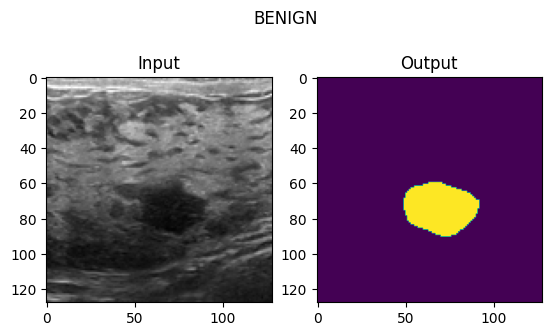

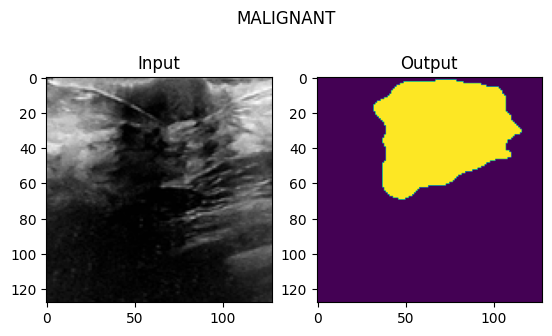

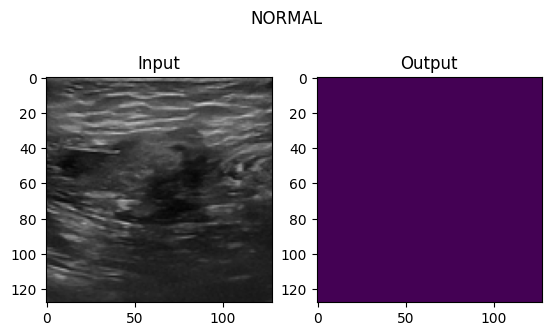

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

for _type in ['benign', 'malignant', 'normal']:
    X = np.load(f'/home/tcd/data/medicalimaging/dataset/{_type}/input.npy')
    y = np.load(f'/home/tcd/data/medicalimaging/dataset/{_type}/target.npy')
    randomExample = random.randint(0, X.shape[0] - 1)
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(X[randomExample])
    axs[0].title.set_text('Input')
    axs[1].imshow(y[randomExample])
    axs[1].title.set_text('Output')
    fig.suptitle(_type.upper())
    plt.subplots_adjust(top=1.1)
    plt.show()

### The problem

You are required to train two separate neural networks for the purposes of:

1. **Classification Task**: Predicting whether an ultrasound is a) benign tumor,  b) contains a malignant tumor or c) normal (no-tumor).
    - Input are ultra sound scans (data from benign/malignant/normal), the output is a vector of the 3 probabilities for the classes (benign/malignant/normal) in that order (eg. [0.01, 0.99, 0] means the outcome is more likely to be malignant).
2. **Segmentation Task**: Predicting the segmentation map for a tumor of an input MRI scan if a tumor exists
    - Input are ultra sound scans (data from benign/malignant/normal), output is an image with the same height and width as the input image, but with only one channel and a value of 1 over the location where a tumor is present.

---

*IMPORTANT*

For Task 1, your model should be created with the name: 'classification_model',
the model size should be under 5M

For Task 2, your model should be created with the name: 'segmentation_model',
the model size should be under 3M.

In [ ]:
# To plot the accuracy graph
import keras
from IPython.display import clear_output
from matplotlib.ticker import MaxNLocator

class PlotLossAccuracy(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.acc = []
        self.losses = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):

        self.logs.append(logs)
        self.x.append(int(self.i))
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))

        self.i += 1

        clear_output(wait=True)
        plt.figure(figsize=(16, 6))
        plt.plot([1, 2])
        plt.subplot(121)
        plt.plot(self.x, self.losses, label="train loss")
        plt.plot(self.x, self.val_losses, label="validation loss")
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.title('Model Loss')
        plt.legend()
        plt.subplot(122)
        plt.plot(self.x, self.acc, label="training accuracy")
        plt.plot(self.x, self.val_acc, label="validation accuracy")
        plt.legend()
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.title('Model Accuracy')
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.show();

In [ ]:
# Hints:

# Load data into appropriate input/output formats.
# For example, for problem 1:
#   * inputs should be a collection of images of size [n_samples x height x width x 3],
#   * outputs should be of size [n_samples x height x width x 1].

# Load images using the `np.load` function. You can combine tensors using `np.concat`
# to form a single input or output dataset tensor. Look at previous labs for inspiration
# on what datasets look like.

# The amount of training data is very low, so usage of data
# augmentation techniques is strongly advised.(eg. see tf.keras.layers.RandomRotation)

# Classification Task hint: you may also think of using pre-trained networks
# with fine-tuning.
# Keep the model size under the restriction of 5Million parameters, you should
# be able to hit the target at much less model size. (Lower the better:))

# Segmentation Task hint: You might want to use transpose convolution layers to go up in tensor size.
# Popular segmentation architectures include U-Net (with skip-connections) or DnCNN.
# Keep the model size under the restriction of 3 Million parameters, you should
# be able to hit the target at very much lower model size. (Lower the better:))

In [ ]:
# Data Loading and Spliting

# Importing necessary libraries
import numpy as np
from sklearn.model_selection import train_test_split

# Loading the data
benign_images = np.load('/home/tcd/data/medicalimaging/dataset/benign/input.npy')
malignant_images = np.load('/home/tcd/data/medicalimaging/dataset/malignant/input.npy')
normal_images = np.load('/home/tcd/data/medicalimaging/dataset/normal/input.npy')

# Create labels in one-hot incoding
benign_labels = np.array([1, 0, 0] * len(benign_images))
malignant_labels = np.array([0, 1, 0] * len(malignant_images))
normal_labels = np.array([0, 0, 1] * len(normal_images))

# Reshape labels to 2D array
benign_labels = benign_labels.reshape(len(benign_images), 3)
malignant_labels = malignant_labels.reshape(len(malignant_images), 3)
normal_labels = normal_labels.reshape(len(normal_images), 3)

# Combine the datasets
X = np.concatenate((benign_images, malignant_images, normal_images), axis=0)
y = np.concatenate((benign_labels, malignant_labels, normal_labels), axis=0)

# Splitting the data into training and testing
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    horizontal_flip=True,
    vertical_flip = True
)

train_generator = datagen.flow(X_train, y_train, batch_size=32, shuffle=True)

In [ ]:
# Classification model

from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from keras.regularizers import l2

# Load the base MobileNetV2 model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3), dropout = 0.75)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='RMSProp', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

if (model.count_params() > 5000000):
    raise Exception("Your model is unecessarily complex, scale down!")

Model: "model_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 64, 64, 32)        128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 64, 64, 32)        288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 64, 64, 32)        128

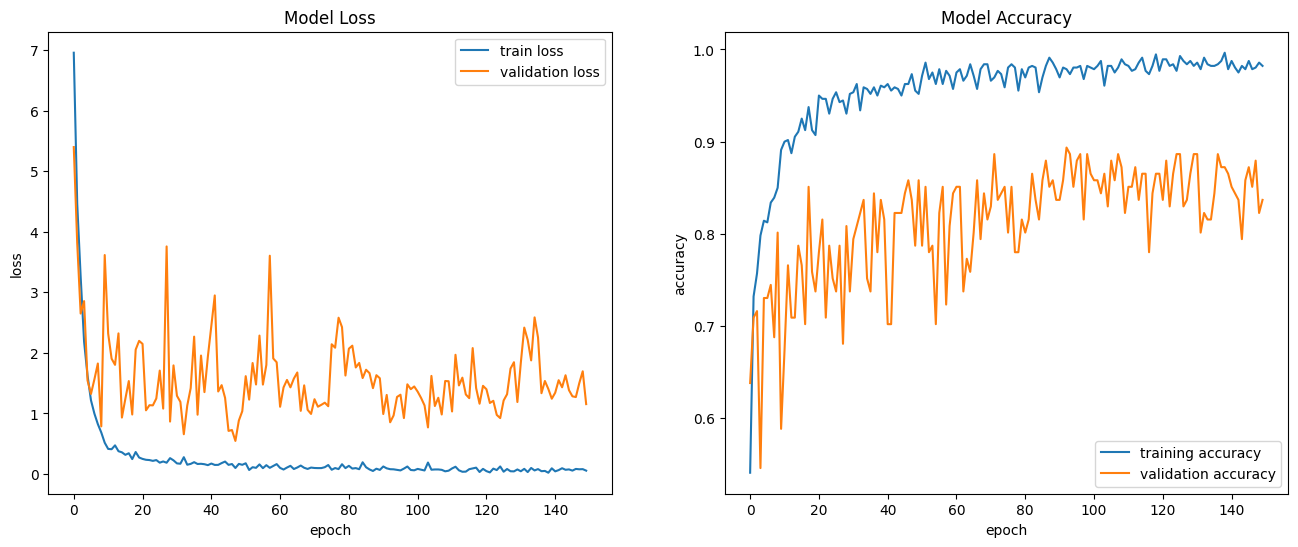

18/18 [==============================] - 3s 187ms/step - loss: 0.0558 - accuracy: 0.9821 - val_loss: 1.1540 - val_accuracy: 0.8369


In [ ]:
# Training Classification model

pltCallBack = PlotLossAccuracy()

history = model.fit(
    train_generator,
    batch_size = 32,
    epochs=150,
    validation_data=(X_val, y_val),
    callbacks=[pltCallBack]
)

In [ ]:
classification_model = model
if (classification_model.count_params()  < 5000000) :
  save_model_to_disk(classification_model, "classification_model")
else:
  print("Your model is unecessarily complex, scale down!")

Saved model to model.json and weights to model.h5


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Load the ultrasound images (inputs)
benign_images = np.load('/home/tcd/data/medicalimaging/dataset/benign/input.npy')
malignant_images = np.load('/home/tcd/data/medicalimaging/dataset/malignant/input.npy')
normal_images = np.load('/home/tcd/data/medicalimaging/dataset/normal/input.npy')

# Load the segmentation maps (targets)
benign_targets = np.load('/home/tcd/data/medicalimaging/dataset/benign/target.npy')
malignant_targets = np.load('/home/tcd/data/medicalimaging/dataset/malignant/target.npy')
normal_targets = np.load('/home/tcd/data/medicalimaging/dataset/normal/target.npy')

# Reshape targets if needed
benign_targets = benign_targets.reshape(-1, 128, 128, 1)
malignant_targets = malignant_targets.reshape(-1, 128, 128, 1)
normal_targets = normal_targets.reshape(-1, 128, 128, 1)

# Combine the datasets
X = np.concatenate((benign_images, malignant_images, normal_images), axis=0)
y = np.concatenate((benign_targets, malignant_targets, normal_targets), axis=0)

# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25)

In [ ]:
import numpy as np
import cv2
import tensorflow as tf

def flip_horizontally(images):
    return np.array([np.fliplr(image) for image in images])

def flip_vertically(images):
    return np.array([np.flipud(image) for image in images])

def blur_images(images, blur_value):
    blurred_images = [cv2.GaussianBlur(image, (5, 5), blur_value) for image in images]
    return np.array(blurred_images).reshape(-1, images.shape[1], images.shape[2], images.shape[3])

# Augmenting benign images
benign_augmented_images = np.concatenate([
    flip_horizontally(benign_images),
    flip_vertically(benign_images),
    blur_images(benign_images, 0.4)
])

benign_augmented_targets = np.concatenate([
    flip_horizontally(benign_targets),
    flip_vertically(benign_targets),
    blur_images(benign_targets, 0.4)
])

# Augmenting malignant images
malignant_augmented_images = np.concatenate([
    flip_horizontally(malignant_images),
    flip_vertically(malignant_images),
    blur_images(malignant_images, 0.4)
])

malignant_augmented_targets = np.concatenate([
    flip_horizontally(malignant_targets),
    flip_vertically(malignant_targets),
    blur_images(malignant_targets, 0.4)
])

# Augmenting normal images
normal_augmented_images = np.concatenate([
    flip_horizontally(normal_images),
    flip_vertically(normal_images),
    blur_images(normal_images, 0.4)
])

normal_augmented_targets = np.concatenate([
    flip_horizontally(normal_targets),
    flip_vertically(normal_targets),
    blur_images(normal_targets, 0.4)
])

X_augmented = np.concatenate((X, benign_augmented_images, malignant_augmented_images, normal_augmented_images))
y_augmented = np.concatenate((y, benign_augmented_targets, malignant_augmented_targets, normal_augmented_targets))

X_train_aug, X_val_aug, y_train_aug, y_val_aug = train_test_split(X_augmented, y_augmented, test_size=0.3)

print(X_train_aug.shape)
print(X_val_aug.shape)
print(y_train_aug.shape)
print(y_val_aug.shape)

(1962, 128, 128, 3)
(842, 128, 128, 3)
(1962, 128, 128, 1)
(842, 128, 128, 1)


In [ ]:
# Segementation model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization,Conv2DTranspose,  Dropout, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from keras.regularizers import l2
import keras
from keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.layers import Activation
import tensorflow as tf


def unet_model(input_size=(128,128,3)):
    inputs = Input(input_size)

    conv0 = Conv2D(8, (3, 3), padding='same', kernel_initializer="he_normal")(inputs)
    bn0 = Activation('relu')(conv0)
    conv0 = Dropout(0.1)(conv0)
    conv0 = Conv2D(8, (3, 3), padding='same', kernel_initializer="he_normal")(bn0)
    bn0 = BatchNormalization(axis=3)(conv0)
    bn0 = Activation('relu')(bn0)
    pool0 = AveragePooling2D(pool_size=(2, 2))(bn0)

    conv1 = Conv2D(16, (3, 3), padding='same', kernel_initializer="he_normal")(pool0)
    bn1 = Activation('relu')(conv1)
    conv1 = Dropout(0.1)(conv1)
    conv1 = Conv2D(16, (3, 3), padding='same', kernel_initializer="he_normal")(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = AveragePooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(32, (3, 3), padding='same', kernel_initializer="he_normal")(pool1)
    bn2 = Activation('relu')(conv2)
    # conv2 = Dropout(0.1)(conv1)
    conv2 = Conv2D(32, (3, 3), padding='same', kernel_initializer="he_normal")(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = AveragePooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(64, (3, 3), padding='same', kernel_initializer="he_normal")(pool2)
    bn3 = Activation('relu')(conv3)
    # conv3 = Dropout(0.1)(conv1)
    conv3 = Conv2D(64, (3, 3), padding='same', kernel_initializer="he_normal")(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = AveragePooling2D(pool_size=(2, 2))(bn3)

    conv5 = Conv2D(64, (3, 3), padding='same', kernel_initializer="he_normal")(pool3)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(64, (3, 3), padding='same', kernel_initializer="he_normal")(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)

    up7 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', kernel_initializer="he_normal")(bn5), conv3])
    conv7 = Conv2D(64, (3, 3), padding='same', kernel_initializer="he_normal")(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(64, (3, 3), padding='same', kernel_initializer="he_normal")(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)

    up8 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', kernel_initializer="he_normal")(bn7), conv2])
    conv8 = Conv2D(32, (3, 3), padding='same', kernel_initializer="he_normal")(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(32, (3, 3), padding='same', kernel_initializer="he_normal")(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    up9 = concatenate([Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same', kernel_initializer="he_normal")(bn8), conv1])
    conv9 = Conv2D(16, (3, 3), padding='same', kernel_initializer="he_normal")(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(16, (3, 3), padding='same', kernel_initializer="he_normal")(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)

    up10 = concatenate([Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same', kernel_initializer="he_normal")(bn9), conv0])
    conv10 = Conv2D(8, (3, 3), padding='same', kernel_initializer="he_normal")(up10)
    bn10 = Activation('relu')(conv10)
    conv10 = Conv2D(8, (3, 3), padding='same', kernel_initializer="he_normal")(bn10)
    bn10 = BatchNormalization(axis=3)(conv10)
    bn10 = Activation('relu')(bn10)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn10)

    return Model(inputs=[inputs], outputs=[conv10])

model = unet_model()
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


# Check the number of parameters
if model.count_params() > 3000000:
    raise ValueError("Model is too large. Reduce the number of parameters.")

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 128, 128, 8)          224       ['input_2[0][0]']             
                                                                                                  
 activation_18 (Activation)  (None, 128, 128, 8)          0         ['conv2d_19[0][0]']           
                                                                                                  
 conv2d_20 (Conv2D)          (None, 128, 128, 8)          584       ['activation_18[0][0]']       
                                                                                            

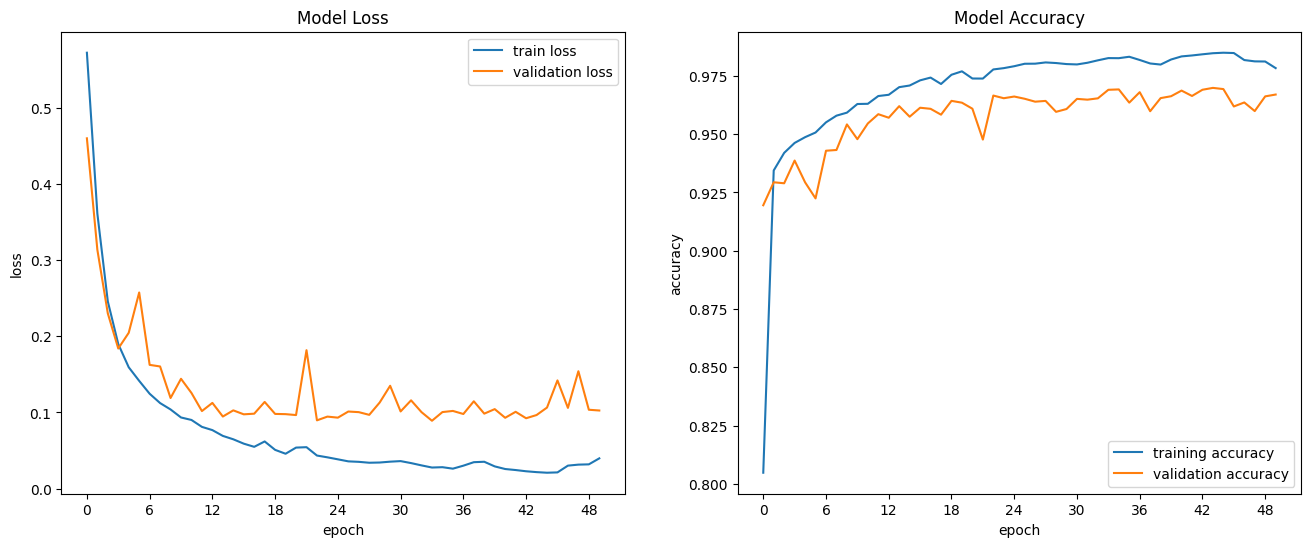

123/123 [==============================] - 4s 30ms/step - loss: 0.0397 - accuracy: 0.9784 - val_loss: 0.1025 - val_accuracy: 0.9670


In [ ]:
pltCallBack = PlotLossAccuracy()

history = model.fit(
    X_train_aug, y_train_aug,
    batch_size = 16,
    epochs=50,
    validation_data=(X_val_aug,y_val_aug),
    shuffle= True,
    callbacks=[pltCallBack]
)



In [ ]:
# F1 score
from sklearn.metrics import f1_score
import numpy as np

train_predictions = model.predict(X_train)
test_predictions = model.predict(X_val)
y_val_flat = y_val.reshape(-1)
test_predictions_flat = test_predictions.reshape(-1)
threshold = 0.5
test_predictions_binary = (test_predictions_flat > threshold).astype(int)
f1 = f1_score(y_val_flat, test_predictions_binary)
print(f"F1 Score: {f1}")

6/6 [==============================] - 0s 11ms/step
F1 Score: 0.9220825806507044


In [ ]:
segmentation_model = model

if (segmentation_model.count_params()  < 3000000) :
  save_model_to_disk(segmentation_model, "segmentation_model")
else:
  print("Your model is unecessarily complex, scale down!")

Saved model to model.json and weights to model.h5
